In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

num_clusters = 3
vector_size = 20

### Labels
walking = 0
pushup = 1
sit-stand = 2
squat = 3

### Walking base

In [56]:
directory = '/home/jovyan/work/backbone/walkingbase'
walking_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        walking_data.append(data_matrix.flatten('F'))

normalized_walking_data = np.vstack(walking_data)
r,c = np.shape(normalized_walking_data)
# normalized_walking_data

walking_labels = np.full((r,1), 0)

### Pushup base

In [57]:
directory = '/home/jovyan/work/backbone/pushupbase'
pushup_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        pushup_data.append(data_matrix.flatten('F'))
#         print(np.shape(data_matrix.flatten('F')))

normalized_pushup_data = np.vstack(pushup_data)
r,c = np.shape(normalized_pushup_data)

pushup_labels = np.full((r,1), 1)

### Sit to stand base

In [58]:
directory = '/home/jovyan/work/backbone/sittostandbase'
sitstand_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        vec_size = np.shape(data_matrix.flatten('F'));
        if vec_size[0] >= vector_size*3:
            sitstand_data.append(data_matrix.flatten('F'))

normalized_sitstand_data = np.vstack(sitstand_data)
r,c = np.shape(normalized_sitstand_data)

sitstand_labels = np.full((r,1), 2)

### Squat base

In [59]:
directory = '/home/jovyan/work/backbone/squatbase'
squat_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        vec_size = np.shape(data_matrix.flatten('F'));
        if vec_size[0] >= vector_size*3:
            squat_data.append(data_matrix.flatten('F'))

normalized_squat_data = np.vstack(squat_data)
r,c = np.shape(normalized_squat_data)

squat_labels = np.full((r,1), 3)

### Data aggregation

In [60]:
# Aggregate all x samples
aggregated_data = []
aggregated_data.append(normalized_pushup_data)
aggregated_data.append(normalized_walking_data)
aggregated_data.append(normalized_sitstand_data)
aggregated_data.append(normalized_squat_data)

# Aggregate all y labels
aggregated_labels = []
aggregated_labels.append(walking_labels)
aggregated_labels.append(sitstand_labels)
aggregated_labels.append(pushup_labels)
aggregated_labels.append(squat_labels)

normalized_X = np.vstack(aggregated_data)
normalized_Y = np.vstack(aggregated_labels)

# Append labels to corresponding row
normalized_X = np.append(normalized_X,normalized_Y, axis=1)

#Shuffle
np.random.shuffle(normalized_X)

# Split back into X and Y
normalized_Y = normalized_X[:,vector_size*3:]
normalized_X = normalized_X[:,:vector_size*3]

#Aggregate X for plotting
normalized_aggregated_data = np.vstack(aggregated_data)

#Shuffle X for plotting
np.random.shuffle(normalized_aggregated_data)

### K-means clustering

In [61]:
# kmeans = KMeans(init='random', n_clusters=num_clusters, max_iter=400, random_state=42)
# kmeans.fit(normalized_X)

### PCA + Kmeans plot

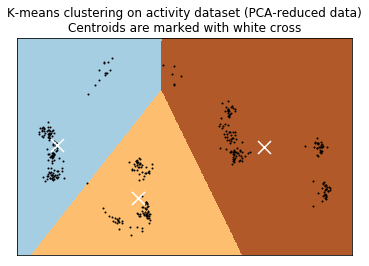

In [62]:
reduced_data = PCA(n_components=2).fit_transform(normalized_aggregated_data)
kmeansPCA = KMeans(init='random', n_clusters=num_clusters, n_init=10)
kmeansPCA.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeansPCA.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeansPCA.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on activity dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Cross-fold validation and Testing

In [63]:
scores = cross_val_score(kmeansPCA, normalized_X, np.ravel(normalized_Y), cv=10, scoring='accuracy')
np.mean(scores)

0.2198435277382646